<div><h1>Innoplexus – Online Hackathon: An Approach to Moral Victory</h1></div><br>

<div align="justify">In this notebook I will be sharing my approach to the innoplexus online hackathon hosted by Analytics Vidhya on 25 May 2018. I achieved a score of <b>0.4588</b>, second place on the public leader board. However, as I lost track of time I was one minute to late with this final submission. For that reason, it does not count towards the private leader board scoring.</div><br>

<div>– Time is what we have most, but what we use worst – #Aziz Shavershian aka Zyzz</div><br>

<div align="justify">I have decided to share my approach because I feel very confident this model would have won the competition, as it comprised only of feature extraction topped with a simple classifier and thus not very prone to be overfitted on the public leader board. Moreover, since the modeling part was so basic (due to time constraints) there is a whole lot of room left for improvement, modeling wise – which might be of interest to you. If so do not hesitate to get back at me!</div><br>

<div>Hope you enjoy,</div>

<div align="right">By wcools <br> aka Alexander de Leeuw <br> wiljancools@gmail.com</div>

<div><h1>Problem statement</h1></div><br>

<div align="justify">As explained on the <a href="https://datahack.analyticsvidhya.com/contest/innoplexus-hiring-hackathon">contest homepage</a>, competitors are asked to come up with a model that can <b>predict for each article which other articles it will cite as a reference.</b></div><br>

<div align="justify">Participants are also notified that there are 18 sets of articles, 9 in the training data and 9 in the test data. The test data is further devided into two parts, a public part containing 5 sets and a private part containing 4 sets.</div><br>

<div>Also, competitors should keep in mind that:
<ul><li>Each set of articles is independent and centred around the same topic e.g. biology</li>
<li>Only articles in the same set can be used as a reference.</li>
<li>Every article has at least one reference</li></ul></div><br>

<div style="margin-top:-10px;" align="justify">The metric used for evaluation is the F1-score weighted by samples: <i> sklearn.metrics.f1_score(y_true, y_pred, average='binary') </i>. What is more, is that the F1-scores are first calculated for each prediction, then averaged per set and then averaged across all sets. This makes a single prediction from a smaller set more important than from a larger set, as every set has the same contribution to the final score.</div><br>

<div><h1>Hacking strategy</h1></div><br>
    
<div align="justify">It is quite astonishing to see that only 50 of the 1863 participants were able to make a significant submission. Which is far below the average of other competitions Analytics Vidhya has hosted, even though the competition lasted 48 hours. This probably has to do with the way the challenge was presented. Observe the target data:</div>

||pm_id|ref_list
|-:|-:| -:
|0|187|['1053', '7500']|
|1|15080|[45753]|

<br><div align="justify">At first, I had no idea how to tackle this problem. Should it be treated as a multilabel classification, should this be considered a recommender engine. I am still not a 100 per cent certain whether the way I solved it, is the best way. That overwhelming feeling of uncertainty in combination with the text features and confusing evaluation metric might have scared some people away, I think. Anyhow, I believe that this is exactly what makes hackathons challenging and fun.</div><br>

<div align="justify">I treated this problem as a binary classification task. With the target variable a boolean <b>is_referenced_flg = True or False</b> and the input data two paired articles and extracted features from these two articles. For training the model I paired all possible articles in each set and checked whether the ref_id was in the ref_list of the pm_id. The previous table thus becomes:</div>

||pm_id|ref_id|features|is_referenced_flg
|-|-|-|-|-|
|0|187|1053| ... |True
|1|187|7500| ... |True
|2|187|15080| ... |False
|3|187|45753| ... |False
|4|15080|187| ... |False
|5|15080|1053| ... |False
|6|15080|7500| ... |False
|7|15080|45753| ... |True

<br><div align="justify">Using the above data table a classification model can be trained. This model can generate a score (pred_proba) for each paired article. After having used this model for scoring it is then a matter of selecting the best performing article pairs. I used a tren-hold #Mike O'Hearn of 0.5. If an article had no pair scoring higher than 0.5, I selected the pair with the highest score. Following this selection procedure, all chosen reference articles are folded into a list to match the format of the provided target data.</div><br>

<div>For example,<br>
The following model output:</div>

||pm_id|ref_id|features|pred_proba
|-|-|-|-|-|
|1|210|950| ... |0.4
|2|210|1600| ... |0.89
|3|210|10200| ... |0.64
|4|19000|56000| ... |0.08
|5|19000|102000| ... |0.23

<br><div>Would generate the following predictions:</div><br>

||pm_id|ref_list
|-:|-:| -:
|0|210|['1600', '10200']|
|1|19000|['102000']|

<a id='123'></a>

# Table of contents

[0) Setup](#0)

[1) Data exploration](#1)

[2) Data wrangling](#2)

[3) Feature engineering](#3)

> [3.1) Basic feature extraction](#31)

> [3.2) Extracting and engineering features from authors](#32)
    
> [3.3) Extracting and engineering features from text fields](#33)
    
> [3.4) Combining features](#34)
 
[4) Data selection and partitioning](#4)

[5) Baseline modeling](#5)

[6) Spotchecking](#6)

[7) Submission](#7)

[8) Reflection](#8)

<a id='0'></a>

# 0) Setup

[Back to table of contents](#123)

In [1]:
# Import some generic libraries
import os
import ast
import time
from IPython.display import display, Image
from collections import OrderedDict, Counter

# Import libraries for data analysis
import math
import pandas as pd
import numpy as np

# Import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for text analysis
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Import machine learning functionalities from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cools\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cools\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read in the data and give the variables a more explanatory and consistent name
to_rename = {'pmid': 'pm_id',
             'article_title': 'title_str',
             'abstract': 'abstract_str',
             'full_Text': 'text_str',
             'author_str': 'authors_str',
             'set': 'set_num'}

info_train = pd.read_csv(r'Data\information_train.csv', sep='\t').rename(to_rename, axis=1)
info_test = pd.read_csv(r'Data\information_test.csv', sep='\t').rename(to_rename, axis=1)
info_all = pd.concat([info_train, info_test], axis=0)
train = pd.read_csv(r'Data\train.csv').rename(to_rename, axis=1)
test = pd.read_csv(r'Data\test.csv').rename(to_rename, axis=1)
sample_sub = pd.read_csv(r'Data\sample_submission_eSUXEfp.csv')

In [3]:
# Generate a function to create more distinctive print output
def neat_print_sperator(name):
    '''A function to create sperations between displays and prints'''
    spacing_len = 95 - len(name)
    print('{} {} {}'.format('_'*math.floor((spacing_len/2)), name, '_'*math.ceil(spacing_len/2)))
    return

<a id='1'></a>

# 1) Data exploration

[Back to table of contents](#123)

In [4]:
# Display different datasets and print their shapes
dataset_dict = OrderedDict((name, eval(name)) for name in ['train', 'info_train', 'test', 'info_test', 'sample_sub'])

for name, dataset in dataset_dict.items():
    neat_print_sperator(name)
    display(dataset.head())
    get_seperator = lambda x: ';' if x[0] > 999 or x[1] > 999 else ','
    print('shape: ({:,}{} {:,})\n'.format(dataset.shape[0], get_seperator(dataset.shape), dataset.shape[1]))

_____________________________________________ train _____________________________________________


,pm_id,ref_list
0,17074820,"['15153999', '15213210', '7668302']"
1,15153999,"['12721363', '9096352', '10788337', '9114021',..."
2,15213210,"['11466240', '12184798']"
3,7668302,['1539589']
4,12721363,"['9465087', '11842208', '11309498', '9465125',..."


shape: (3,522; 2)

__________________________________________ info_train ___________________________________________


,abstract_str,title_str,authors_str,pm_id,pub_date,set_num,text_str
0,"Among bioethicists and members of the public, ...",The routinisation of genomics and genetics: im...,"M W Foster, C D M Royal, R R Sharp",17074820,2006-11-01,13,NaN
1,Genomics resources that use samples from ident...,Integrating ethics and science in the Internat...,NaN,15153999,2008-02-25,13,NaN
2,Alleviating health disparities in the United S...,Genetic Research and Health Disparities,"Pamela Sankar, Mildred K. Cho, Celeste M. Cond...",15213210,2008-02-20,13,NaN
3,Protecting the confidentiality of genetic rese...,Certificates of confidentiality: a valuable to...,"C L Earley, L C Strong",7668302,1995-09-01,13,NaN
4,Whereas the human linkage map appears on limit...,Linkage disequilibrium in human populations,"Christine Lonjou, Weihua Zhang, Andrew Collins...",12721363,2003-05-13,13,NaN


shape: (3,522; 7)

_____________________________________________ test ______________________________________________


,pm_id
0,14058267
1,4550818
2,14222809
3,4164675
4,6211173


shape: (2,034; 1)

___________________________________________ info_test ___________________________________________


,abstract_str,title_str,authors_str,pm_id,pub_date,set_num,text_str
0,Cell lines selected in multiple steps for incr...,"The gene for a novel protein, a member of the ...","M M Chaudhuri, P N Tonin, W H Lewis, P R Srini...",1311171,1992-02-01,17,NaN
1,Prolyl 4-hydroxylase (EC 1.14.11.2) is an esse...,Inhibition of prolyl 4-hydroxylase by hydroxya...,"C J Cunliffe, T J Franklin",3028370,1986-10-15,17,NaN
2,From the structure-activity relationships of k...,Time-dependent inactivation of chick-embryo pr...,"V Gunzler, H M Hanauske-Abel, R Myllyla, J Moh...",3036081,1987-02-15,17,NaN
3,The anthracyclines doxorubicin and daunorubici...,Syncatalytic inactivation of prolyl 4-hydroxyl...,"V Gunzler, H M Hanauske-Abel, R Myllyla, D D K...",2840891,1988-04-15,17,NaN
4,The levels of lysine hydroxylase protein and t...,Minoxidil specifically decreases the expressio...,"T Hautala, J Heikkinen, K I Kivirikko, R Myllyla",1314568,1992-04-01,17,NaN


shape: (2,034; 7)

__________________________________________ sample_sub ___________________________________________


,pmid,ref_list
0,14058267,"['13367334','13367334']"
1,4550818,['13367334']
2,14222809,['13367334']
3,4164675,['13367334']
4,6211173,['13367334']


shape: (2,034; 2)



In [5]:
# Observe some data
for name in info_train.columns:
    neat_print_sperator(name)
    display(info_train.loc[0, name])

_________________________________________ abstract_str __________________________________________


'Among bioethicists and members of the public, genetics is often regarded as unique in its ethical challenges. As medical researchers and clinicians increasingly combine genetic information with a range of non‐genetic information in the study and clinical management of patients with common diseases, the unique ethical challenges attributed to genetics must be re‐examined. A process of genetic routinisation that will have implications for research and clinical ethics, as well as for public conceptions of genetic information, is constituted by the emergence of new forms of genetic medicine, in which genetic information is interpreted in a multifactorial frame of reference. Although the integration of genetics in medical research and treatment may be a helpful corrective to the mistaken assumptions of genetic essentialism or determinism, the routinisation of genetics may have unintended consequences for the protection of genetic information, perceptions of non‐genetic information and the 

___________________________________________ title_str ___________________________________________


'The routinisation of genomics and genetics: implications for ethical practices'

__________________________________________ authors_str __________________________________________


'M W Foster, C D M Royal, R R Sharp'

_____________________________________________ pm_id _____________________________________________


17074820

___________________________________________ pub_date ____________________________________________


'2006-11-01'

____________________________________________ set_num ____________________________________________


13

___________________________________________ text_str ____________________________________________


nan

<a id='2'></a>

# 2) Data wrangling

[Back to table of contents](#123)

In [6]:
# Get all possible pm_id combinations per set
all_pm_id_combs = []
for set_n in info_all.set_num.unique():
    t = list(info_all.loc[info_all.set_num == set_n, 'pm_id'])
    all_pm_id_combs = all_pm_id_combs + ['{}-{}'.format(x,y) for x in t for y in t if x != y]

# Get all pm_id combinations that are referenced
flagged_pm_id_combs = []
for i, row in train.iterrows():
    pm_id = row['pm_id']
    ref_list = ast.literal_eval(row['ref_list'])
    flagged_pm_id_combs = flagged_pm_id_combs + ['{}-{}'.format(pm_id, ref) for ref in ref_list]
    
# Get all pm_id in unlabeld data
unlabeled_pm_id_combs = []
for set_n in info_test.set_num.unique():
    t = list(info_test.loc[info_test.set_num == set_n, 'pm_id'])
    unlabeled_pm_id_combs = unlabeled_pm_id_combs + ['{}-{}'.format(x,y) for x in t for y in t if x != y]

# Use all pm_id combinations to build a labelled dataframe
data = pd.DataFrame(all_pm_id_combs).rename(columns={0:'pm_ref_id'})
data['pm_id'] = data['pm_ref_id'].apply(lambda x: x.split('-')[0]).astype(int)
data['ref_id'] = data['pm_ref_id'].apply(lambda x: x.split('-')[1]).astype(int)
data['is_referenced_flg'] = False
data.loc[data.pm_ref_id.isin(flagged_pm_id_combs), 'is_referenced_flg'] = True
data.loc[data.pm_ref_id.isin(unlabeled_pm_id_combs), 'is_referenced_flg'] = np.nan
data = data.drop(columns='pm_ref_id')

# Set list with ids for later
ids = ['pm_id', 'ref_id']

# Observe data
display(data.loc[[1,2,3,4,2274862,2274863], :])

,pm_id,ref_id,is_referenced_flg
1,17074820,15213210,1.0
2,17074820,7668302,1.0
3,17074820,12721363,0.0
4,17074820,9096352,0.0
2274862,4335249,5775847,NaN
2274863,4335249,13514006,NaN


In [7]:
# Change the index of the info_train dataframe to make mapping easier, whilst not overwriting the original dataframe
articles = info_all.copy()
articles.index = articles['pm_id']
articles = articles.drop(columns='pm_id')

# Enrich dataframe with both info of pm- and ref-article by mapping the articles
for col in [col for col in articles.columns if col != 'set_num']:
    mapper = articles[col]
    
    if col == 'pub_date':
        mapper = pd.to_datetime(mapper)
    
    data['pm_' + col] = data['pm_id'].map(mapper)
    data['ref_' + col] = data['ref_id'].map(mapper)

# Transmit set number aswell (is the same for both pm- and ref-article)
data['set_num'] = data.pm_id.map(articles['set_num'])

# Observe dataframe
data.head()

# Observe data
display(data.loc[[1,2,3,4,2274862,2274863], :])

,pm_id,ref_id,is_referenced_flg,pm_abstract_str,ref_abstract_str,pm_title_str,ref_title_str,pm_authors_str,ref_authors_str,pm_pub_date,ref_pub_date,pm_text_str,ref_text_str,set_num
1,17074820,15213210,1.0,"Among bioethicists and members of the public, ...",Alleviating health disparities in the United S...,The routinisation of genomics and genetics: im...,Genetic Research and Health Disparities,"M W Foster, C D M Royal, R R Sharp","Pamela Sankar, Mildred K. Cho, Celeste M. Cond...",2006-11-01,2008-02-20,NaN,NaN,13
2,17074820,7668302,1.0,"Among bioethicists and members of the public, ...",Protecting the confidentiality of genetic rese...,The routinisation of genomics and genetics: im...,Certificates of confidentiality: a valuable to...,"M W Foster, C D M Royal, R R Sharp","C L Earley, L C Strong",2006-11-01,1995-09-01,NaN,NaN,13
3,17074820,12721363,0.0,"Among bioethicists and members of the public, ...",Whereas the human linkage map appears on limit...,The routinisation of genomics and genetics: im...,Linkage disequilibrium in human populations,"M W Foster, C D M Royal, R R Sharp","Christine Lonjou, Weihua Zhang, Andrew Collins...",2006-11-01,2003-05-13,NaN,NaN,13
4,17074820,9096352,0.0,"Among bioethicists and members of the public, ...",We have examined differences in diversity at 6...,The routinisation of genomics and genetics: im...,Microsatellite diversity and the demographic h...,"M W Foster, C D M Royal, R R Sharp","Lynn B. Jorde, Alan R. Rogers, Michael Bamshad...",2006-11-01,1997-04-01,NaN,NaN,13
2274862,4335249,5775847,NaN,Membrane-envelope fragments have been isolated...,Mitochondria were prepared from the spadices o...,RESPIRATION AND PROTEIN SYNTHESIS IN ESCHERICH...,The Respiratory Chain of Plant Mitochondria. I...,"R. Scharff, R. W. Hendler, N. Nanninga, A. H. ...","Bayard T. Storey, James T. Bahr",1972-04-01,1969-01-01,NaN,NaN,19
2274863,4335249,13514006,NaN,Membrane-envelope fragments have been isolated...,Respiration of a normal strain of Candida albi...,RESPIRATION AND PROTEIN SYNTHESIS IN ESCHERICH...,RESPIRATORY METABOLISM OF NORMAL AND DIVISIONL...,"R. Scharff, R. W. Hendler, N. Nanninga, A. H. ...","John M. Ward, Walter J. Nickerson",1972-04-01,1958-03-20,NaN,NaN,19


<a id='3'></a>

# 3) Feature engineering

[Back to table of contents](#123)
<a id='31'></a>

## 3.1) Basic feature extraction

[Back to table of contents](#123)

In [8]:
# Extract time difference between publication date of pm- and ref-article
data['diff_pub_date_day_cnt'] = (data['pm_pub_date'] - data['ref_pub_date']).astype('timedelta64[D]').astype(int)

# Extract plucation years of pm- and ref-article
data['pm_pub_year_num'] = data['pm_pub_date'].apply(lambda x: x.year)
data['ref_pub_year_num'] = data['ref_pub_date'].apply(lambda x: x.year)

# Count the authors of pm- and ref-article
lmbda = lambda x: len(str(x).split(', ')) if not pd.isnull(x) else 0
data['pm_author_cnt'] = data['pm_authors_str'].apply(lmbda)
data['ref_author_cnt'] = data['ref_authors_str'].apply(lmbda)

# Extract missing value flags for authors of pm- and ref-article
data['pm_author_mv_flg'] = data['pm_authors_str'].isnull()
data['ref_author_mv_flg'] = data['ref_authors_str'].isnull()

# Extract missing value flags for text of pm- and ref-article
data['pm_full_text_mv_flg'] = data['pm_text_str'].isnull()
data['ref_full_text_mv_flg'] = data['ref_text_str'].isnull()

# Count charachters used in the title of pm- and ref-article
data['pm_title_char_cnt'] = data['pm_title_str'].apply(lambda x: len(x))
data['ref_title_char_cnt'] = data['ref_title_str'].apply(lambda x: len(x))

# Count words used in the title of pm- and ref-article
data['pm_title_word_cnt'] = data['pm_title_str'].apply(lambda x: len(x.split(' ')))
data['ref_title_word_cnt'] = data['ref_title_str'].apply(lambda x: len(x.split(' ')))

# Count charachters used in the abstract of pm- and ref-article
data['pm_abstract_char_cnt'] = data['pm_abstract_str'].apply(lambda x: len(x))
data['ref_abstract_char_cnt'] = data['ref_abstract_str'].apply(lambda x: len(x))

# Count words used in the abstract of pm- and ref-article
data['pm_abstract_word_cnt'] = data['pm_abstract_str'].apply(lambda x: len(x.split(' ')))
data['ref_abstract_word_cnt'] = data['ref_abstract_str'].apply(lambda x: len(x.split(' ')))

In [9]:
# Observe created features
data[[col for col in data.columns if not col.endswith('str')]].head()

,pm_id,ref_id,is_referenced_flg,pm_pub_date,ref_pub_date,set_num,diff_pub_date_day_cnt,pm_pub_year_num,ref_pub_year_num,pm_author_cnt,...,pm_full_text_mv_flg,ref_full_text_mv_flg,pm_title_char_cnt,ref_title_char_cnt,pm_title_word_cnt,ref_title_word_cnt,pm_abstract_char_cnt,ref_abstract_char_cnt,pm_abstract_word_cnt,ref_abstract_word_cnt
0,17074820,15153999,1.0,2006-11-01,2008-02-25,13,-481,2006,2008,3,...,True,True,78,66,10,9,1238,907,177,131
1,17074820,15213210,1.0,2006-11-01,2008-02-20,13,-476,2006,2008,3,...,True,True,78,39,10,5,1238,998,177,143
2,17074820,7668302,1.0,2006-11-01,1995-09-01,13,4079,2006,1995,3,...,True,True,78,77,10,10,1238,880,177,129
3,17074820,12721363,0.0,2006-11-01,2003-05-13,13,1268,2006,2003,3,...,True,True,78,43,10,5,1238,1703,177,254
4,17074820,9096352,0.0,2006-11-01,1997-04-01,13,3501,2006,1997,3,...,True,True,78,69,10,7,1238,1219,177,171


<a id='32'></a>

## 3.2) Extracting and engineering features from authors

[Back to table of contents](#123)

In [10]:
# Extract common authors in pm- and ref-article
common_authors_list = []
for i, row in data.iterrows():
    if pd.isnull(row['pm_authors_str']) or pd.isnull(row['ref_authors_str']):
        common_authors_list.append(np.nan)
    else:
        pm_author_list = row['pm_authors_str'].split(', ')
        ref_author_list = row['ref_authors_str'].split(', ')
        common_authors_list.append(list(set(pm_author_list).intersection(ref_author_list)))
        
data['common_authors_list'] = common_authors_list

# Count common authors in pm- and ref-article
lmbda = lambda x: len(x) if type(x) != type(np.nan) else 0
data['common_authors_cnt'] = data['common_authors_list'].apply(lmbda)

In [11]:
# Clean all author strings
def authors_to_list(x):
    x = re.sub('\r|\n', '', x)
    x = x.split(', ')
    return(x)

info_all['authors_list'] = info_all.authors_str.fillna('').astype(str).apply(authors_to_list)
data['pm_authors_list'] = data['pm_authors_str'].fillna('').astype(str).apply(authors_to_list)
data['ref_authors_list'] = data['ref_authors_str'].fillna('').astype(str).apply(authors_to_list)

# Creaet dict with authors and their publications
author_dict = {}
for i, row in info_all.iterrows():
    for author in row['authors_list']:
        if author in author_dict.keys():
            author_dict[author].append(row['set_num'])
        else:
            author_dict[author] = [row['set_num']]
            
# Set the publications of the missing value author to an empty string            
author_dict[''] = ''

# Extract min, max and mean amount of publications for the authors of both pm- and ref-article
results = {}
for i, row in data.iterrows():   
    pm_author_pub_counts = []
    for author in row['pm_authors_list']:
        pm_author_pub_counts.append(len(author_dict[author]))
    
    ref_author_pub_counts = []
    for author in row['ref_authors_list']:
        ref_author_pub_counts.append(len(author_dict[author]))
    
    # max, mean, min? sum       
    results[i] = [max(pm_author_pub_counts), np.mean(pm_author_pub_counts),
                  min(pm_author_pub_counts), sum(pm_author_pub_counts),
                  max(ref_author_pub_counts), np.mean(ref_author_pub_counts),
                  min(ref_author_pub_counts), sum(ref_author_pub_counts)]
                  
df_r = pd.DataFrame(results, index=['pm_authors_max_pub_cnt', 'pm_authors_mean_pub_cnt',
                                    'pm_authors_min_pub_cnt', 'pm_authors_total_pub_cnt',
                                    'ref_authors_max_pub_cnt', 'ref_authors_mean_pub_cnt',
                                    'ref_authors_min_pub_cnt', 'ref_authors_total_pub_cnt']).transpose()

data = pd.concat([data, df_r], axis=1)

In [12]:
# Remove text features
to_drop = [col for col in data.columns if col.endswith('str') or col.endswith('list') or col.endswith('date') ]
data = data.drop(columns=to_drop)

# Observe current dataframe
data.head()

,pm_id,ref_id,is_referenced_flg,set_num,diff_pub_date_day_cnt,pm_pub_year_num,ref_pub_year_num,pm_author_cnt,ref_author_cnt,pm_author_mv_flg,...,ref_abstract_word_cnt,common_authors_cnt,pm_authors_max_pub_cnt,pm_authors_mean_pub_cnt,pm_authors_min_pub_cnt,pm_authors_total_pub_cnt,ref_authors_max_pub_cnt,ref_authors_mean_pub_cnt,ref_authors_min_pub_cnt,ref_authors_total_pub_cnt
0,17074820,15153999,1.0,13,-481,2006,2008,3,0,False,...,131,0,2.0,1.666667,1.0,5.0,0.0,0.000000,0.0,0.0
1,17074820,15213210,1.0,13,-476,2006,2008,3,8,False,...,143,0,2.0,1.666667,1.0,5.0,1.0,1.000000,1.0,8.0
2,17074820,7668302,1.0,13,4079,2006,1995,3,2,False,...,129,0,2.0,1.666667,1.0,5.0,1.0,1.000000,1.0,2.0
3,17074820,12721363,0.0,13,1268,2006,2003,3,7,False,...,254,0,2.0,1.666667,1.0,5.0,4.0,2.285714,1.0,16.0
4,17074820,9096352,0.0,13,3501,2006,1997,3,8,False,...,171,0,2.0,1.666667,1.0,5.0,5.0,2.000000,1.0,16.0


<a id='33'></a>

## 3.3) Extracting and engineering features from text fields

[Back to table of contents](#123)

** HELPER FUNCTIONS**

In [13]:
# Instantiations from the natural language toolkit
stop_words = nltk.corpus.stopwords.words('english')
word_punct_tokenizer = nltk.WordPunctTokenizer()

port_stemmer = nltk.stem.PorterStemmer()
word_net_lemmatizer = nltk.stem.WordNetLemmatizer()

In [14]:
# Create some helper functions
def get_pos(word):
    wordnet_synsets = nltk.corpus.wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts['n'] = len([ item for item in wordnet_synsets if item.pos()== 'n'])
    pos_counts['v'] = len([ item for item in wordnet_synsets if item.pos()== 'v'])
    pos_counts['a'] = len([ item for item in wordnet_synsets if item.pos()== 'a'])
    pos_counts['r'] = len([ item for item in wordnet_synsets if item.pos()== 'r'])
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

def document_normalizer(doc, how='stemming'):
    # Strip everything but white spaces and alpha numeric
    doc = re.sub('([^\s\w]|_)+', '', doc)
    
    # Tokenize document, lowercase tokens and remove tokens that have length of 1
    tokens = [token.lower() for token in word_punct_tokenizer.tokenize(doc) if len(token) > 1]
    
    # Filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    if how == 'stemming':
        # Stem tokens 
        cleaned_tokes = [port_stemmer.stem(token) for token in filtered_tokens]
    elif how == 'lemmatization':
        # Lemmatize tokens
        cleaned_tokes = [word_net_lemmatizer.lemmatize(token, get_pos(token)) for token in filtered_tokens]
    else:
        raise ValueError('Specify how to normalize')
        
    # Re-create document from cleaned tokens
    doc = ' '.join(cleaned_tokes)
    
    return doc

corpus_normalizer = np.vectorize(document_normalizer)

def n3gram(norm_corpus, dataframe_ids, min_dif=1, max_df=0.5, ngram_range=(1,3)):
    cv = CountVectorizer(min_df=min_dif, max_df=max_df, ngram_range=ngram_range)
    
    cv_matrix = cv.fit_transform(norm_corpus).toarray()
    cv_df = pd.DataFrame(cv_matrix, columns=cv.get_feature_names(), index=dataframe_ids)
    
    cv_sim_matrix = cosine_similarity(cv_matrix)
    cv_sim_df = pd.DataFrame(cv_sim_matrix, index=dataframe_ids, columns=dataframe_ids)
    
    return cv_sim_df, cv_df

def tfidf(norm_corpus, dataframe_ids, min_dif=1, max_df=0.5, ngram_range=(1,1)):
    tv = TfidfVectorizer(min_df=1, max_df=0.5, ngram_range=ngram_range, use_idf=True)
    
    tv_matrix = tv.fit_transform(norm_corpus).toarray()  
    tv_df = pd.DataFrame(tv_matrix, columns=tv.get_feature_names(), index=dataframe_ids)
    
    tv_sim_matrix = cosine_similarity(tv_matrix)
    tv_sim_df = pd.DataFrame(tv_sim_matrix, index=dataframe_ids, columns=dataframe_ids)
    
    return tv_sim_df, tv_df

** SHOW CASE HOW HELPER FUNCTIONS WORK **

In [15]:
# Sample some observations (of which some are referenced)
sample = data.loc[[0,1,3,4], ['pm_id', 'ref_id', 'is_referenced_flg']]
sample

,pm_id,ref_id,is_referenced_flg
0,17074820,15153999,1.0
1,17074820,15213210,1.0
3,17074820,12721363,0.0
4,17074820,9096352,0.0


In [16]:
# Create a sample corpus
sample_ids = list(sample['pm_id'].unique()) + list(sample['ref_id'])
sample_corpus  = info_train.loc[train.pm_id.isin(sample_ids), 'title_str']
sample_corpus.index = sample_ids

In [17]:
# Show how lemmatizer and stemmer work
space_evener = lambda x: ' '*(8-len(str(x)))

neat_print_sperator('original')
print()
for i in range(0,5):
    print('{}{}: {}'.format(sample_ids[i], space_evener(sample_ids[i]),sample_corpus.iloc[i]))
    print()

neat_print_sperator('stemmed')
print()
for i in range(0,5):
    print('{}{}: {}'.format(sample_ids[i], space_evener(sample_ids[i]),
                            corpus_normalizer(sample_corpus.iloc[i], how='stemming')))
    print()

neat_print_sperator('lemmatized')
print()
for i in range(0,5):
    print('{}{}: {}'.format(sample_ids[i], space_evener(sample_ids[i]),
                            corpus_normalizer(sample_corpus.iloc[i], how='lemmatization')))
    print()

___________________________________________ original ____________________________________________

17074820: The routinisation of genomics and genetics: implications for ethical practices

15153999: Integrating ethics and science in the International HapMap Project

15213210: Genetic Research and Health Disparities

12721363: Linkage disequilibrium in human populations

9096352 : Microsatellite diversity and the demographic history of modern humans

____________________________________________ stemmed ____________________________________________

17074820: routinis genom genet implic ethic practic

15153999: integr ethic scienc intern hapmap project

15213210: genet research health dispar

12721363: linkag disequilibrium human popul

9096352 : microsatellit divers demograph histori modern human

__________________________________________ lemmatized ___________________________________________

17074820: routinisation genomics genetics implication ethical practice

15153999: integrate et

In [18]:
# Show how 3gram works
norm_corpus = corpus_normalizer(sample_corpus, how='stemming')
similarity_df, features_df =  n3gram(norm_corpus, max_df=0.5, dataframe_ids=sample_corpus.index)

neat_print_sperator('Extracted stemmed 3gram features')
display(features_df)
print()

neat_print_sperator('Similarity matrix of stemmed 3gram features')
display(similarity_df.applymap(lambda x: '{:0.2}'.format(x)))

_______________________________ Extracted stemmed 3gram features ________________________________


,demograph,demograph histori,demograph histori modern,disequilibrium,disequilibrium human,disequilibrium human popul,dispar,divers,divers demograph,divers demograph histori,...,project,research,research health,research health dispar,routinis,routinis genom,routinis genom genet,scienc,scienc intern,scienc intern hapmap
17074820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
15153999,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1
15213210,0,0,0,0,0,0,1,0,0,0,...,0,1,1,1,0,0,0,0,0,0
12721363,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9096352,1,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0



__________________________ Similarity matrix of stemmed 3gram features __________________________


,17074820,15153999,15213210,12721363,9096352
17074820,1.0,0.067,0.086,0.0,0.0
15153999,0.067,1.0,0.0,0.0,0.0
15213210,0.086,0.0,1.0,0.0,0.0
12721363,0.0,0.0,0.0,1.0,0.086
9096352,0.0,0.0,0.0,0.086,1.0


In [19]:
# Show how tfidf works
norm_corpus = corpus_normalizer(sample_corpus, how='lemmatization')
similarity_df, features_df =  tfidf(norm_corpus, max_df=0.5, dataframe_ids=sample_corpus.index)

neat_print_sperator('Extracted lemmatized tfidf features')
display(features_df.applymap(lambda x: '{:0.2}'.format(x)))
print()

neat_print_sperator('Similarity matrix of lemmatized tfidf features')
display(similarity_df.applymap(lambda x: '{:0.2}'.format(x)))

______________________________ Extracted lemmatized tfidf features ______________________________


,demographic,disequilibrium,disparity,diversity,ethic,ethical,genetic,genetics,genomics,hapmap,...,international,linkage,microsatellite,modern,population,practice,project,research,routinisation,science
17074820,0.0,0.0,0.0,0.0,0.0,0.41,0.0,0.41,0.41,0.0,...,0.0,0.0,0.0,0.0,0.0,0.41,0.0,0.0,0.41,0.0
15153999,0.0,0.0,0.0,0.0,0.41,0.0,0.0,0.0,0.0,0.41,...,0.41,0.0,0.0,0.0,0.0,0.0,0.41,0.0,0.0,0.41
15213210,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
12721363,0.0,0.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.52,0.0,0.0,0.52,0.0,0.0,0.0,0.0,0.0
9096352,0.42,0.0,0.0,0.42,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.42,0.42,0.0,0.0,0.0,0.0,0.0,0.0



________________________ Similarity matrix of lemmatized tfidf features _________________________


,17074820,15153999,15213210,12721363,9096352
17074820,1.0,0.0,0.0,0.0,0.0
15153999,0.0,1.0,0.0,0.0,0.0
15213210,0.0,0.0,1.0,0.0,0.0
12721363,0.0,0.0,0.0,1.0,0.14
9096352,0.0,0.0,0.0,0.14,1.0


** ACTUAL FEATURE EXTRACTION FROM TEXT FIELDS**

In [20]:
# Create similarity matrices using the titles
corpus = info_all['title_str'].astype(str)

norm_corpus = corpus_normalizer(corpus, how='stemming')
n3gram_stem_title_sim_matrix, _ =  n3gram(norm_corpus, dataframe_ids=info_all['pm_id'])
tfidf_stem_title_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

norm_corpus = corpus_normalizer(corpus, how='lemmatization')
n3gram_lemma_title_sim_matrix, _ = n3gram(norm_corpus, dataframe_ids=info_all['pm_id'])
tfidf_lemma_title_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

In [21]:
# Create similarity matrices using the authors
corpus = info_all['authors_str'].fillna('').astype(str)

ynorm_corpus = corpus_normalizer(corpus, how='stemming')
n3gram_stem_author_sim_matrix, _ =  n3gram(norm_corpus, dataframe_ids=info_all['pm_id'])
tfidf_stem_author_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

norm_corpus = corpus_normalizer(corpus, how='lemmatization')
n3gram_lemma_author_sim_matrix, _ = n3gram(norm_corpus, dataframe_ids=info_all['pm_id'])
tfidf_lemma_author_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

In [22]:
# Create similarity matrices using the abstracts
corpus = info_all['abstract_str'].astype(str)

norm_corpus = corpus_normalizer(corpus, how='stemming')
tfidf_stem_abstract_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

norm_corpus = corpus_normalizer(corpus, how='lemmatization')
tfidf_lemma_abstract_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

In [23]:
# Create similarity matrices concatenating all text fields
corpus = (info_all['authors_str'].fillna('').astype(str) + ' ' +  info_all['title_str'].astype(str) + ' ' + 
          info_all['abstract_str'].astype(str) + ' ' + info_all['text_str'].fillna('').astype(str))

norm_corpus = corpus_normalizer(corpus, how='stemming')
tfidf_stem_all_strings_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

norm_corpus = corpus_normalizer(corpus, how='lemmatization')
tfidf_lemma_all_strings_sim_matrix, _ = tfidf(norm_corpus, dataframe_ids=info_all['pm_id'])

In [24]:
# Create a function to retrief the similarity score for every pm_id and ref_id pair, in every similarity matrix
def get_similarity_scores(matrices, data):
    results = {}
    for i, row in data.iterrows():
        results[i] = []
        for matrix in matrices:
            results[i].append(matrix.at[row['pm_id'], row['ref_id']])
    return results

In [25]:
# Enriche the labeled dataframe with similarity scores
sim_matrices = [n3gram_stem_title_sim_matrix, tfidf_stem_title_sim_matrix,
                n3gram_lemma_title_sim_matrix, tfidf_lemma_title_sim_matrix,
                n3gram_stem_author_sim_matrix, tfidf_stem_author_sim_matrix,
                n3gram_lemma_author_sim_matrix, tfidf_lemma_author_sim_matrix,
                tfidf_stem_abstract_sim_matrix, tfidf_lemma_abstract_sim_matrix,
                tfidf_stem_all_strings_sim_matrix, tfidf_lemma_all_strings_sim_matrix]


sim_scores_dict = get_similarity_scores(sim_matrices, data)

sim_feature_names = ['n3gram_stem_title_sim_score', 'tfidf_stem_title_sim_score',
                     'n3gram_lemma_title_sim_score', 'tfidf_lemma_title_sim_score',
                     'n3gram_stem_author_sim_score', 'tfidf_stem_author_sim_score',
                     'n3gram_lemma_author_sim_score', 'tfidf_lemma_author_sim_score',
                     'tfidf_stem_abstract_sim_score', 'tfidf_lemma_abstract_sim_score',
                     'tfidf_stem_all_strings_sim_score', 'tfidf_lemma_all_strings_sim_score']


df_r = pd.DataFrame(sim_scores_dict, index=sim_feature_names).transpose()

data = pd.concat([data, df_r], axis=1)

In [26]:
# Observe created features
neat_print_sperator('all text based similarity features')
data[ids + sim_feature_names].head()

______________________________ all text based similarity features _______________________________


,pm_id,ref_id,n3gram_stem_title_sim_score,tfidf_stem_title_sim_score,n3gram_lemma_title_sim_score,tfidf_lemma_title_sim_score,n3gram_stem_author_sim_score,tfidf_stem_author_sim_score,n3gram_lemma_author_sim_score,tfidf_lemma_author_sim_score,tfidf_stem_abstract_sim_score,tfidf_lemma_abstract_sim_score,tfidf_stem_all_strings_sim_score,tfidf_lemma_all_strings_sim_score
0,17074820,15153999,0.066667,0.221658,0.0,0.0,0.0,0.0,0.0,0.0,0.298858,0.216477,0.313161,0.240701
1,17074820,15213210,0.086066,0.087672,0.0,0.0,0.0,0.0,0.0,0.0,0.181894,0.154654,0.175891,0.146273
2,17074820,7668302,0.060858,0.059911,0.0,0.0,0.0,0.0,0.0,0.0,0.198521,0.159695,0.181761,0.136338
3,17074820,12721363,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.040751,0.046429,0.034123,0.036943
4,17074820,9096352,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027104,0.030748,0.019998,0.022334


<a id='34'></a>

# 3.4) Combining features

[Back to table of contents](#123)

In [27]:
# Create variable containing the total amount of members (pm-ids) for every set
data['set_members_cnt'] = data['set_num'].map(data.groupby('set_num').agg('count')['pm_id'])
data['real_set_members_cnt'] = data['set_members_cnt'].pow(1./2)

In [28]:
# Create mean variable encodings per set
to_set_mean_cols = [col for col in data.columns if (col.endswith('cnt') or col.endswith('flg')) and
                                                         col not in ['is_referenced_flg', 'diff_pub_date_day_cnt']]

for col in to_set_mean_cols:
    name = re.sub('pm_', '', col)
    name = name + '_set_mean_enc'
    data[name] = data['set_num'].map(data.groupby('set_num').agg('mean')[col])
    
set_mean_cols = [re.sub('pm_', '', col) + '_set_mean_enc' for col in to_set_mean_cols]

# Obseve for one feature
example_cols = ids +['set_num'] + [set_mean_cols[0]]
display(data.loc[data.set_num.isin([5,18]), example_cols].sample(5))

,pm_id,ref_id,set_num,author_cnt_set_mean_enc
1624417,5812474,4169338,5,2.553785
120729,16513741,12761086,18,5.611413
1709430,4978744,4623313,5,2.553785
1563296,1275890,4180276,5,2.553785
1576496,6222136,3131772,5,2.553785


In [29]:
# Calculate difference with mean set encodings for both pm- and ref-features
pairs = []
for i in range(0, len(to_set_mean_cols)):
    pairs.append([set_mean_cols[i], to_set_mean_cols[i]])

for pair in pairs:
    name = pair[1] + '_diff_with_set_mean_enc'
    data[name] = data[pair[0]] - data[pair[1]]
    
    if 'pm_' in pair[1]:
        pair1 = re.sub('pm_', 'ref_', pair[1])
        
        name = pair1 + '_diff_with_set_mean_enc'
        data[name] = data[pair[0]] - data[pair1]
        
diff_with_set_mean_cols = [col + '_diff_with_set_mean_enc' for col in to_set_mean_cols]

# Obseve for one feature
example_cols = ids + ['set_num', set_mean_cols[0], to_set_mean_cols[0], diff_with_set_mean_cols[0]]
display(data[example_cols].head(10))

,pm_id,ref_id,set_num,author_cnt_set_mean_enc,pm_author_cnt,pm_author_cnt_diff_with_set_mean_enc
0,17074820,15153999,13,6.114679,3,3.114679
1,17074820,15213210,13,6.114679,3,3.114679
2,17074820,7668302,13,6.114679,3,3.114679
3,17074820,12721363,13,6.114679,3,3.114679
4,17074820,9096352,13,6.114679,3,3.114679
5,17074820,10788337,13,6.114679,3,3.114679
6,17074820,9114021,13,6.114679,3,3.114679
7,17074820,10330360,13,6.114679,3,3.114679
8,17074820,9634526,13,6.114679,3,3.114679
9,17074820,11466240,13,6.114679,3,3.114679


In [30]:
# Take some differences between -pm and ref-features
pm_cols = [col for col in data.columns if col.startswith('pm_') and  '_id' not in col
           and not col.endswith('_set_mean_enc') and not col.endswith('_flg')] 
ref_cols = [col for col in data.columns if col.startswith('ref_') and  '_id' not in col
            and not col.endswith('_set_mean_enc') and not col.endswith('_flg')]

pairs = []
for i in range(0, len(pm_cols)):
    pairs.append([pm_cols[i], ref_cols[i]])

for pair in pairs:
    name = re.sub('pm_', 'diff_', pair[0])
    data[name] = data[pair[0]] - data[pair[1]]
        
diff_cols = [re.sub('pm_', 'diff_', col) for col in pm_cols]

# Obseve for one feature
example_cols = ids + ['set_num', pm_cols[1], ref_cols[1], diff_cols[1]]
display(data[example_cols].sample(5))

example_cols = ids + [pm_cols[1], ref_cols[1], diff_cols[1]]
display(data[example_cols].head(5))

,pm_id,ref_id,set_num,pm_author_cnt,ref_author_cnt,diff_author_cnt
272288,6960359,4360942,16,2,5,-3
2101061,4945194,4945192,9,2,2,0
1221499,2162479,3548708,3,5,3,2
689720,7048316,3905848,16,2,3,-1
190869,6097599,6321771,16,3,7,-4


,pm_id,ref_id,pm_author_cnt,ref_author_cnt,diff_author_cnt
0,17074820,15153999,3,0,3
1,17074820,15213210,3,8,-5
2,17074820,7668302,3,2,1
3,17074820,12721363,3,7,-4
4,17074820,9096352,3,8,-5


In [31]:
# Take some sums of pm- and ref-flag-features
pm_cols = [col for col in data.columns if col.startswith('pm_') and col.endswith('flg')] 
ref_cols = [col for col in data.columns if col.startswith('ref_') and col.endswith('flg')]

pairs = []
for i in range(0, len(pm_cols)):
    pairs.append([pm_cols[i], ref_cols[i]])

for pair in pairs:
    name = re.sub('pm_', 'sum_', pair[0])
    data[name] = data[pair[0]].astype(int) + data[pair[1]].astype(int)

sum_cols = [re.sub('pm_', 'sum_', col) for col in pm_cols]
    
example_cols = ids + ['set_num', pm_cols[0], ref_cols[0], sum_cols[0]]

# Obseve for one feature
display(data[example_cols].head())

,pm_id,ref_id,set_num,pm_author_mv_flg,ref_author_mv_flg,sum_author_mv_flg
0,17074820,15153999,13,False,True,1
1,17074820,15213210,13,False,False,0
2,17074820,7668302,13,False,False,0
3,17074820,12721363,13,False,False,0
4,17074820,9096352,13,False,False,0


<a id='4'></a>

# 4) Data selection and partitioning

[Back to table of contents](#123)

In [32]:
# Identify columns that temporary should be dropped and not be used for training, but are still useful afterwards
to_drop = ids + ['set_num']

In [33]:
# Create different partitions for train and validations set
train_sets = info_train.set_num.unique()[::2]
val_sets = [s for s in info_train.set_num.unique() if s not in train_sets]

# Use partitions to split the data
X_train = data.loc[data.set_num.isin(train_sets), [col for col in data.columns if col != 'is_referenced_flg']]
y_train = data.loc[data.set_num.isin(train_sets), 'is_referenced_flg']

X_val = data.loc[data.set_num.isin(val_sets), [col for col in data.columns if col != 'is_referenced_flg']]
y_val = data.loc[data.set_num.isin(val_sets), 'is_referenced_flg']

<a id='5'></a>

# 5) Baseline modeling

[Back to table of contents](#123)

** SNIPPET FROM EARLY ON IN THE COMPETITION **

In [34]:
# Set steps of pipeline
steps = [('ss', StandardScaler()),
         ('lr', LogisticRegression(random_state=123))]

# Chain pipeline into model
bl_model = Pipeline(steps)

# Train model
bl_model.fit(X_train.drop(columns=to_drop), y_train)

# Make predictions
y_train_pred_proba = bl_model.predict_proba(X_train.drop(columns=to_drop))[:,1]
y_val_pred_proba = bl_model.predict_proba(X_val.drop(columns=to_drop))[:,1]

In [35]:
# Observe general model performance
print('train roc auc: {:.4f}'.format(roc_auc_score(y_train, y_train_pred_proba)))
print('val roc auc:   {:.4f}'.format(roc_auc_score(y_val, y_val_pred_proba)))

train roc auc: 0.9117
val roc auc:   0.9250


In [36]:
# Observe general model performance
y_train_pred = y_train_pred_proba > 0.5
y_val_pred = y_val_pred_proba > 0.5

print('train f1:      {:.4f}'.format(f1_score(y_train, y_train_pred)))
print('val f1:        {:.4f}'.format(f1_score(y_val, y_val_pred)))

train f1:      0.1658
val f1:        0.1914


** HELPER FUCNTIONS FOR REAL EVALUATION **

In [37]:
# Generate predictions (in correct format)
def pred_generator(df, threshold=0.5):
    if sum(df['pred_proba'] > threshold) > 0:
        to_return = str(list(df.loc[df['pred_proba'] > threshold, 'ref_id'].astype(str)))
    else:
        to_return = str([df.loc[df['pred_proba'].idxmax(), 'ref_id'].astype(str)])
    return to_return

In [38]:
# Create dataframe with predictions of model
predictions = X_train[['pm_id', 'ref_id']].copy()
predictions['pred_proba'] = y_train_pred_proba

neat_print_sperator('model output')
display(predictions.head())

# Apply the helper function
predictions = predictions.groupby('pm_id').apply(pred_generator).to_frame()
predictions = predictions.reset_index().rename(columns={0: 'ref_list'})

# Get order of pm ids in original data
correct_order = info_train.loc[info_train.set_num.isin(train_sets), ['pm_id', 'set_num']]

# Give predictions the same order
predictions = pd.merge(correct_order, predictions, on='pm_id')

# Compare
neat_print_sperator('predictions')
display(predictions.drop(columns='set_num').head())

neat_print_sperator('original')
display(train.head())

_________________________________________ model output __________________________________________


,pm_id,ref_id,pred_proba
0,17074820,15153999,0.145136
1,17074820,15213210,0.020658
2,17074820,7668302,0.052667
3,17074820,12721363,0.004583
4,17074820,9096352,0.007041


__________________________________________ predictions __________________________________________


,pm_id,ref_list
0,17074820,['15153999']
1,15153999,['17074820']
2,15213210,['1539589']
3,7668302,['1539589']
4,12721363,"['11842208', '12486239', '7942858']"


___________________________________________ original ____________________________________________


,pm_id,ref_list
0,17074820,"['15153999', '15213210', '7668302']"
1,15153999,"['12721363', '9096352', '10788337', '9114021',..."
2,15213210,"['11466240', '12184798']"
3,7668302,['1539589']
4,12721363,"['9465087', '11842208', '11309498', '9465125',..."


In [39]:
# Generate input for f1 scorer
def f1_input_generator(y, ys):
    to_return = []
    for i in sorted(set(ys)):
        if i in y:
            to_return.append(1)
        else:
            to_return.append(0)
    return to_return

In [40]:
# Set some dummy predictions
y_true = [1,3]
y_pred = [1,4]

# Get input for F1_score
y_true_input = f1_input_generator(y_true, y_true + y_pred)
y_pred_input = f1_input_generator(y_pred, y_true + y_pred)

score = f1_score(y_true_input, y_pred_input, average='binary')

# Show
print('y_true:      ', y_true)
print('y_pred:      ', y_pred)
print('labels:      ', sorted(set(y_true + y_pred)))
print('y_true_input:', y_true_input)
print('y_pred_input:', y_pred_input)
print('F1 score:    ', score)


y_true:       [1, 3]
y_pred:       [1, 4]
labels:       [1, 3, 4]
y_true_input: [1, 1, 0]
y_pred_input: [1, 0, 1]
F1 score:     0.5


** PUTTING IT ALL TOGETHER **

In [41]:
def get_f1_scores(X, pred_proba, sets):
    predictions = X[['pm_id', 'ref_id']].copy()
    predictions['pred_proba'] = pred_proba
    predictions = predictions.groupby('pm_id').apply(pred_generator).to_frame()
    predictions = predictions.reset_index().rename(columns={0: 'ref_list'})
    
    correct_order = info_train.loc[info_train.set_num.isin(sets), ['pm_id', 'set_num']]
    predictions = pd.merge(correct_order, predictions, on='pm_id')

    actuals = pd.merge(correct_order, train, on='pm_id')
    scores = {}
    for set_n in predictions.set_num.unique():
        scores[set_n] = []
        for i, row in predictions.loc[predictions.set_num == set_n, :].iterrows():
            y_true = ast.literal_eval(actuals.loc[i, 'ref_list'])
            y_pred = ast.literal_eval(row['ref_list'])

            y_true_input = f1_input_generator(y_true, y_true + y_pred)
            y_pred_input = f1_input_generator(y_pred, y_true + y_pred)

            score = f1_score(y_true_input, y_pred_input, average='binary')

            scores[set_n].append(score)

    mean_scores = {}
    for set_n in predictions.set_num.unique():
        mean_scores[set_n] = np.mean(scores[set_n])
    
    df = pd.Series(mean_scores).to_frame().rename(columns={0: 'mean f1 scores'})
    df.index.name = 'set_num'
    
    return df

In [42]:
# Get mean f1 scores and take overall score
train_scores = get_f1_scores(X_train, y_train_pred_proba, train_sets)
neat_print_sperator('{}: {:0.4f}'.format('training', train_scores.mean().values[0]))
display(train_scores)

val_scores = get_f1_scores(X_val, y_val_pred_proba, val_sets)
neat_print_sperator('{}: {:0.4f}'.format('validation', val_scores.mean().values[0]))
display(val_scores)

_______________________________________ training: 0.2503 ________________________________________


,mean f1 scores
set_num,
3,0.194999
5,0.268413
6,0.353517
13,0.246834
16,0.187599


______________________________________ validation: 0.2730 _______________________________________


,mean f1 scores
set_num,
2,0.355639
8,0.207172
14,0.219899
18,0.309300


<a id='6'></a>

 # 6) Spotchecking

[Back to table of contents](#123)

In [43]:
# Instantiate classifiers
classifiers = [
#                ('KNeighborsClassifier', KNeighborsClassifier()),
#                ('RadiusNeighborsClassifier', RadiusNeighborsClassifier(radius=5)),
               
#                ('PassiveAggressiveClassifier', PassiveAggressiveClassifier(random_state=123)),
#                ('Perceptron', Perceptron(random_state=123)),
#                ('RidgeClassifier', RidgeClassifier(random_state=123)),
#                ('LogisticRegression', LogisticRegression(random_state=123, n_jobs=-1)),
               ('SGDClassifier', SGDClassifier(random_state=123, n_jobs=-1)),
               
#                ('LinearSVC', LinearSVC()),
#                ('NuSVC', NuSVC()),
#                ('SVC', SVC()),
               
               ('AdaBoostClassifier', AdaBoostClassifier(random_state=123)),
               ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=123, n_jobs=-1)),
               ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=123)),
               ('RandomForestClassifier', RandomForestClassifier(random_state=123, n_jobs=-1)),
               
               ('MLPClassifier', MLPClassifier(random_state=123)),
               
#                ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=123)),
#                ('ExtraTreeClassifier', ExtraTreeClassifier(random_state=123)),
               
#                ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
#                ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()),
               
#                ('BernoulliNB', BernoulliNB()),
#                ('GaussianNB', GaussianNB()),
#                ('MultinomialNB', MultinomialNB()),
               
#                ('GaussianProcessClassifier', GaussianProcessClassifier(random_state=123, n_jobs=-1))
              ]

# Put classifiers in a series object
clfs = pd.Series()
for clf_name, clf in classifiers:
    clfs[clf_name] = clf

In [44]:
# Get spotcheking results
spch_preds = {}
for i, clf_name in enumerate(clfs.index):
    
#     t1 = time.time()
    
    steps = [('ss', StandardScaler()), (clf_name, clfs[clf_name])]
    spch_model = Pipeline(steps)
    spch_model.fit(X_train.drop(columns=to_drop), y_train)
    
    try:
        y_train_spch_pred = spch_model.predict_proba(X_train.drop(columns=to_drop))[:,1]
        y_val_spch_pred = spch_model.predict_proba(X_val.drop(columns=to_drop))[:,1]
         
    except:
        y_train_spch_pred = spch_model.predict(X_train.drop(columns=to_drop))
        y_val_spch_pred = spch_model.predict(X_val.drop(columns=to_drop))
        
    t2 = time.time()
    
#     print('{} done in {:.0f}s'.format(clf_name, t2 - t1))
    print('{} done fitting and predicting'.format(clf_name))
    
    spch_preds[clf_name] = [y_train_spch_pred, y_val_spch_pred]

SGDClassifier done fitting and predicting
AdaBoostClassifier done fitting and predicting
ExtraTreesClassifier done fitting and predicting
GradientBoostingClassifier done fitting and predicting
RandomForestClassifier done fitting and predicting
MLPClassifier done fitting and predicting


In [45]:
# Observe model performance
spch_scores = {}
for clf_name, preds in spch_preds.items():
    spch_scores[clf_name] = [roc_auc_score(y_train, preds[0]), roc_auc_score(y_val, preds[1])]
    spch_scores[clf_name] += [f1_score(y_train, preds[0] > 0.5), f1_score(y_val, preds[1] > 0.5)]
    
df = pd.DataFrame.from_dict(spch_scores, orient='index')
df.columns = ['train_roc_auc', 'val_roc_auc', 'train_f1', 'val_f1']
df = df.sort_values('val_f1', ascending=False)
df.round(4)

,train_roc_auc,val_roc_auc,train_f1,val_f1
AdaBoostClassifier,0.9587,0.9485,0.2862,0.3226
GradientBoostingClassifier,0.9566,0.9507,0.3024,0.2754
SGDClassifier,0.5736,0.6063,0.2137,0.2441
RandomForestClassifier,1.0000,0.8588,0.9177,0.2365
MLPClassifier,0.9650,0.8867,0.3360,0.2032
ExtraTreesClassifier,1.0000,0.8119,1.0000,0.1127


In [46]:
# Evaluate real performance
eval_results= {}
for clf in spch_preds.keys():
    train_scores = get_f1_scores(X_train, spch_preds[clf][0], train_sets)
    val_scores = get_f1_scores(X_val, spch_preds[clf][1], val_sets)
    
    mean_train_score = round(train_scores.mean().values[0],4)
    mean_val_score = round(val_scores.mean().values[0], 4)
    
    eval_results[clf] = [mean_train_score, mean_val_score]
    
df = pd.DataFrame.from_dict(eval_results).transpose()
df.columns = ['mean_train_f1_score', 'mean_val_f1_score']
df = df.sort_values('mean_val_f1_score', ascending=False)
df.round(4)

,mean_train_f1_score,mean_val_f1_score
AdaBoostClassifier,0.3430,0.3839
GradientBoostingClassifier,0.3618,0.3717
MLPClassifier,0.3510,0.3485
RandomForestClassifier,0.9365,0.3136
ExtraTreesClassifier,0.9981,0.2490
SGDClassifier,0.2011,0.1968


<a id='7'></a>

# 7) Submission

[Back to table of contents](#123)

In [47]:
# Refit final model on all training data
X = data.loc[~data.is_referenced_flg.isnull(), [col for col in data.columns if col != 'is_referenced_flg']]
y = data.loc[~data.is_referenced_flg.isnull(), 'is_referenced_flg']

X_ulbld = data.loc[data.is_referenced_flg.isnull(), [col for col in data.columns if col != 'is_referenced_flg']]

steps = [('ss', StandardScaler()),
         ('abc', AdaBoostClassifier(random_state=123))]

final_model = Pipeline(steps)

final_model.fit(X.drop(columns=to_drop), y)

pred_proba = final_model.predict_proba(X_ulbld.drop(columns=to_drop))[:,1]

In [48]:
# Create predictions
predictions = X_ulbld[['pm_id', 'ref_id']].copy()
predictions['pred_proba'] = pred_proba
predictions = predictions.groupby('pm_id').apply(pred_generator).to_frame()
predictions = predictions.reset_index().rename(columns={0: 'ref_list'})

correct_order = test[['pm_id']]
predictions = pd.merge(correct_order, predictions, on='pm_id')
predictions = predictions.rename(columns={'pm_id': 'pmid'})
display(predictions.head())
print('shape: ({:,}; {:})'.format(dataset.shape[0], dataset.shape[1]))

,pmid,ref_list
0,14058267,['13814573']
1,4550818,['14273645']
2,14222809,"['13885712', '14381435', '13398435', '14381436..."
3,4164675,['14176294']
4,6211173,"['6451217', '6211171']"


shape: (2,034; 2)


In [49]:
# Create "bumission" file
predictions.to_csv(r'Data\Submissions\final bumission.csv', index=False)

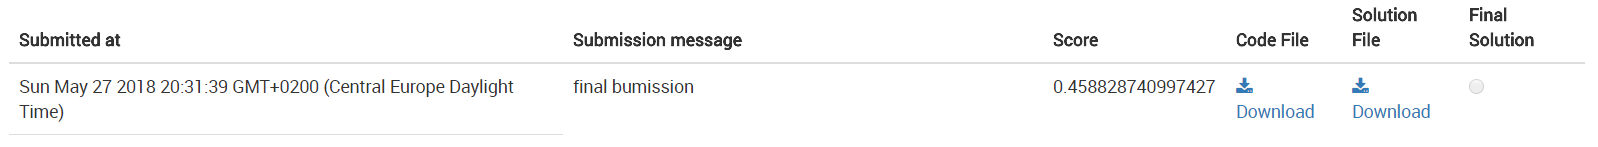

In [50]:
# Check performance of final "bumission"
Image('final bumission.png')

<a id='8'></a>

# 8) Reflection

[Back to table of contents](#123)

<div align="justify">First off, I could have manged my time better, haha. Of course, if I had made my final submission a bit earlier I would not be saying this. However, from a performance point of view I put a bit too much effort in engineering features. Because at the end I had no time to do any fancy modeling. I spot checked only a hand full of models, performed no hyperparameter tuning, or any grid search of that kind, I did not stack any models into a neat ensemble and I also did not tune the tren-hold (#Mike again). Whereas the problem setup absolutely lends itself to this, as every set could be used as a cross-validation-fold. On top of that, I still left a lot of feature generation possibilities to boost tree-based model performance untouched: like frequency encodings, mean-target encodings, feature rankings etc. So, there is still plenty of room to boost the performance of the current model.</div><br>

<div align="justify">Near the deadline of the competition I noticed that some of the full texts contained references inside them, I was not able to fully investigate and exploit this, but I decided to run a tfidf on the concatenation of the full text and the authors, which ended up working very well. Moreover, there was no need to construct a test set for this problem as it was clearly communicated how the public part of the leader board was made. Hence, competitors knew for a fact that the predictions scores on the public leader board would be representative for the performance. In many competitions this is not the case. The public part of the leader board is often formed by a random split, making it unbalanced and pretty much useless, unless for leader board probing of course. Anyway, I am a firm believer of not making too many submissions as it will just lead to plain overfitting. Furthermore, a well-constructed validation scheme should give sufficient feedback (or no validation scheme at all in my case).</div><br>

<div align="justify">To wrap up, some minor things that could be improved: I think Innoplexus could have put more effort in explaining the evaluation metric, as I had a hard time figuring this out (and so did others apparently) – it might be more convenient to give a formula, or at least some more examples. Next, I would very much like Analytics Vidhya to make discussions more accessible and code sharing mandatory or at least easier. Anyway, I am just nit-picking. I really enjoyed this experience. I would like to thank them both, Innoplexus for the challenging problem, Analytics Vidhya for the great hacking experience – AND you for competing!</div><br>

<div>– Eat clean & mine dirty –  #Rich Piana</div><br><br><br><br>